# Traitement des images

### Approches proposées:
- Test de faisabilité
- Un prétraitement des données image
- Extraction de features:
    - un algorithme de type SIFT
    - un algorithme de type CNN Transfer Learning

## Imports

In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import tensorflow as tf
from wordcloud import WordCloud
import multiprocessing

import nltk
import string
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn import cluster, metrics, preprocessing, linear_model, neighbors
from sklearn import manifold
from sklearn.svm import SVC

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16

from glob import glob

#### Message d'avertissements

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Imports données

In [3]:
data = pd.read_csv("./Data/DataTraite.csv")
data.head()

Unnamed: 0                           uniq_id            crawl_timestamp  \
0           0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1           1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2           2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3           3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4           4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  ...  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  ...   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg  ...   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg  ...   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg  ...   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg  ...   

               2th_category num_categories  \
0   Curtains & Accessories             4.0   
1         Baby Bath & Skin             5.0   
2         Baby Bath & Skin             5.0   
3                Bed Linen             5.0   
4                Bed Linen             5.0   

                                           name_desc  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1  Sathiyas Cotton Bath Towel Specifications of S...   
2  Eurospa Cotton Terry Face Towel Set Key Featur...   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                     name_desc_clean  \
0  elegance polyester multicolor abstract eyelet ...   
1  cotton bath towel of cotton bath towel bath to...   
2  cotton terry face towel set key of cotton terr...   
3  royal fashion cotton printed king sized double...   
4  print cotton floral king sized double key of p...   

                               name_desc_clean_wo_sw  \
0  elegance polyester multicolor abstract eyelet ...   
1  cotton bath towel cotton bath towel bath towel...   
2  cotton terry face towel set key cotton terry f...   
3  royal fashion cotton printed king sized double...   
4  print cotton floral king sized double key prin...   

                                 name_desc_clean_lem  \
0  elegance polyester multicolor abstract eyelet ...   
1  cotton bath towel specification cotton bath to...   
2  cotton terry face towel set key feature cotton...   
3  royal fashion cotton printed king sized double...   
4  print cotton floral king sized double key feat...   

                                name_desc_clean_stem  \
0  multicolor abstract eyelet door curtain key mu...   
1  cotton bath towel cotton bath towel bath towel...   
2  cotton face towel set key cotton face towel se...   
3  royal fashion cotton print king size key royal...   
4  print cotton floral king s

## Observations du dataset

In [4]:
df = data[['image','main_category']].copy()

In [10]:
df['image'] = ('./Data/Images/') + df['image']

In [12]:
#Encodage target
label= preprocessing.LabelEncoder()
df.loc[:,'label'] = label.fit_transform(df['main_category'])

In [13]:
df

image     main_category  \
0     ./Data/Images/55b85ea15a1536d46b7190ad6fff8ce7...  Home Furnishing    
1     ./Data/Images/7b72c92c2f6c40268628ec5f14c6d590...        Baby Care    
2     ./Data/Images/64d5d4a258243731dc7bbb1eef49ad74...        Baby Care    
3     ./Data/Images/d4684dcdc759dd9cdf41504698d737d8...  Home Furnishing    
4     ./Data/Images/6325b6870c54cd47be6ebfbffa620ec7...  Home Furnishing    
...                                                 ...               ...   
1045  ./Data/Images/958f54f4c46b53c8a0a9b8167d9140bc...        Baby Care    
1046  ./Data/Images/fd6cbcc22efb6b761bd564c28928483c...        Baby Care    
1047  ./Data/Images/5912e037d12774bb73a2048f35a00009...        Baby Care    
1048  ./Data/Images/c3edc504d1b4f0ba6224fa53a43a7ad6...        Baby Care    
1049  ./Data/Images/f2f027ad6a6df617c9f125173da71e44...        Baby Care    

      label  
0         4  
1         0  
2         0  
3         4  
4         4  
...     ...  
1045      0  
1046      0  
1047      0  
1048      0  
1049      0  

[1050 rows x 3 columns]

### Visualisation de 3 images par catégories

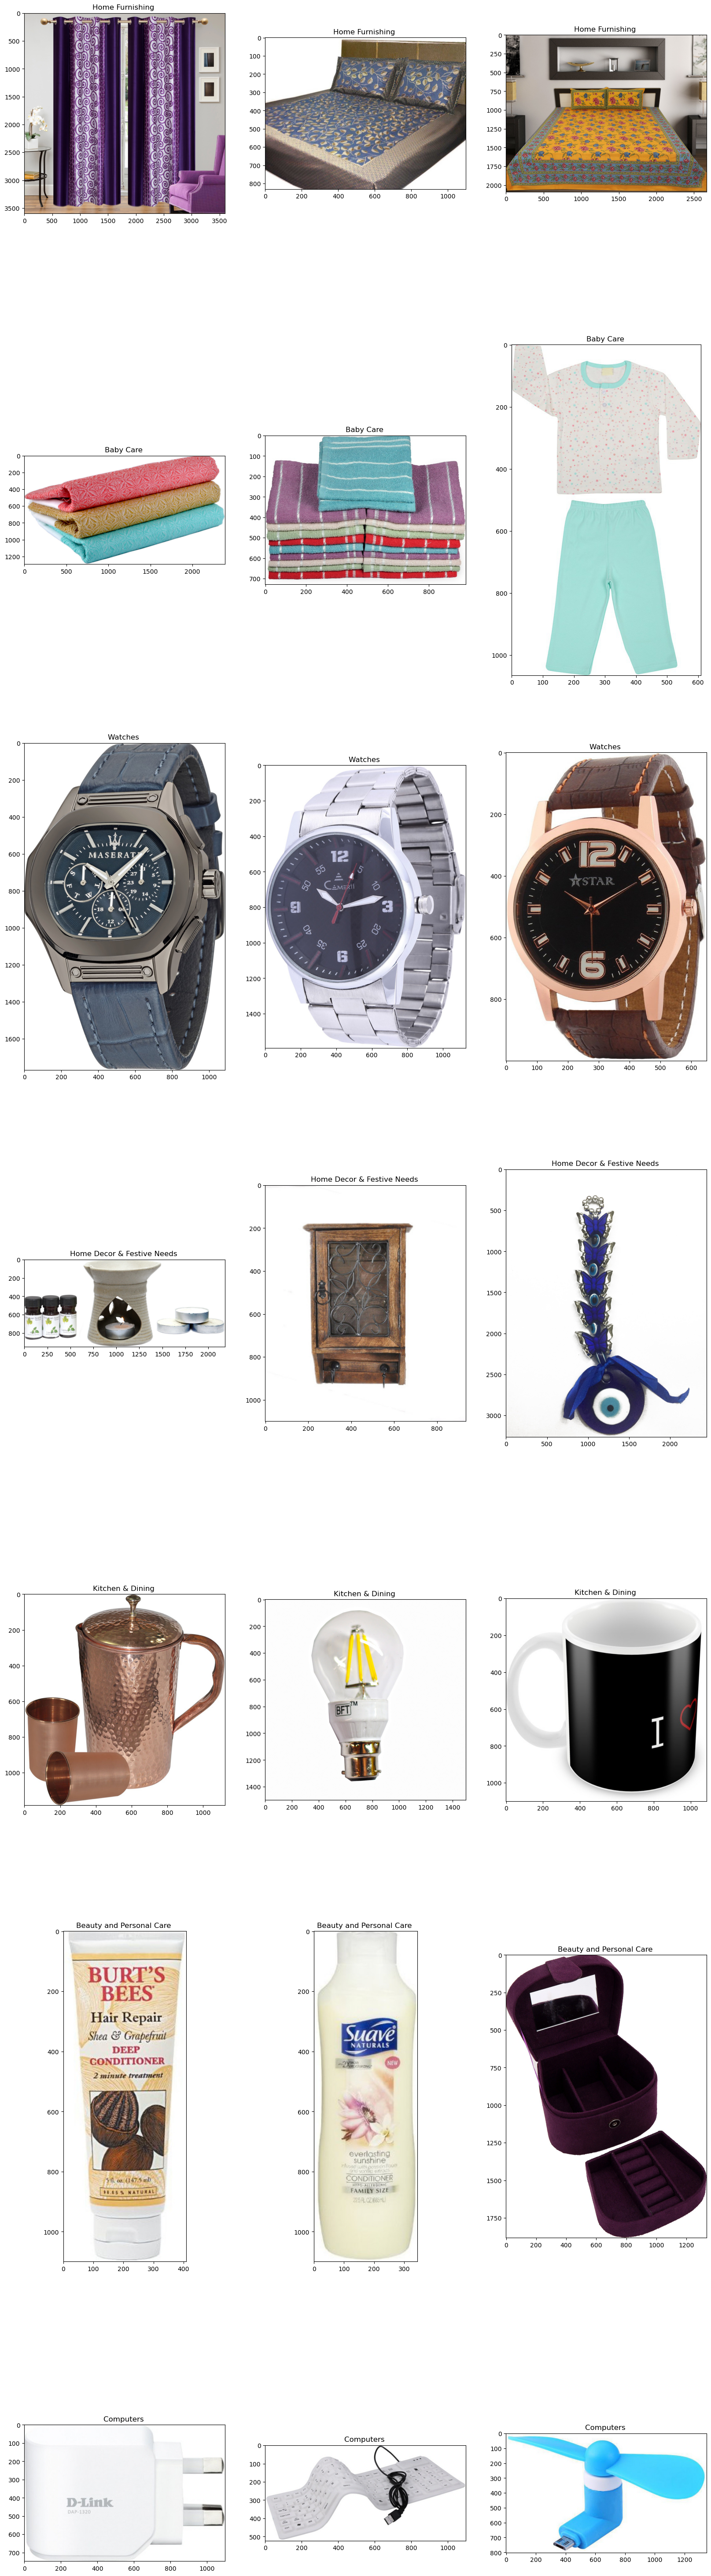

In [104]:
from matplotlib.image import imread

cat = df['main_category'].unique()
n = 0
plt.figure(figsize=(20,80))
for l in cat:
    df_2 = df.loc[df['main_category']==l]
    
    for i in range(3):
        plt.subplot(7,3,(n+i)+1)
        image = imread(df_2.iloc[i,0])
        plt.imshow(image)
        plt.title("{}".format(l))
    n = n+3
plt.show()

## Test de faisabilité

### Modèle pré-entraîné

In [105]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [106]:
images_features = []
i=0 
for image_file in df.loc[:,"image"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    # output du modele
    images_features.append(model.predict(image, verbose=0)[0]) 

df_img = np.asarray(images_features)
df_img.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

#### Réduction de dimension

In [107]:
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(df_img)
feat_pca.shape

(1050, 803)

#### Observations:

Il y a 803 composantes ACP, on va utiliser t-SNE pour visualiser et voir s'il y a des classes qui se regroupent, puis les comparer aux clusters générés par K-Means

In [108]:
# t-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=5000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

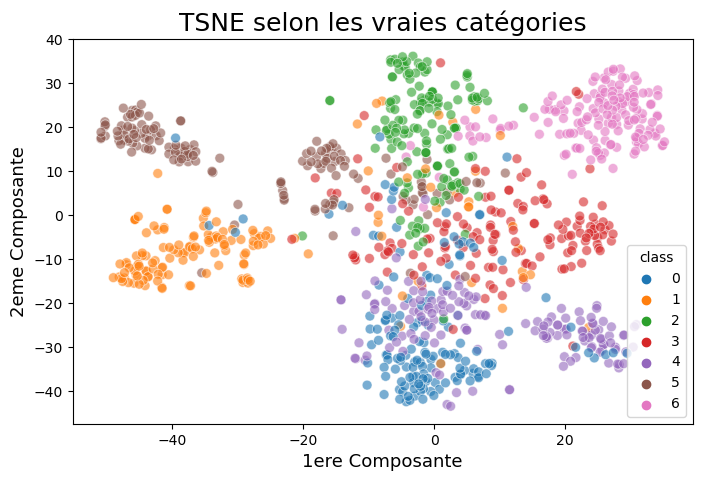

ARI: 0.4509604716846339


In [109]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label"]

#Visualisation
plt.figure(figsize=(8,5))
sns.scatterplot(x="tsne1", y="tsne2",hue="class",palette=sns.color_palette('tab10', n_colors=7),\
                s=50, alpha=0.6,data=df_tsne,legend="brief")
plt.title('TSNE selon les vraies catégories', fontsize = 18)
plt.xlabel('1ere Composante', fontsize = 13)
plt.ylabel('2eme Composante', fontsize = 13) 

plt.show()

cls = cluster.KMeans(n_clusters=7)
cls.fit(X_tsne)
lab_km = cls.labels_

print('ARI:', metrics.adjusted_rand_score(df.loc[:,'label'], lab_km))

## Features Extraction et classification

### SIFT et Classifier

On réalise une features Extraction via SIFT, en faisant varier le threshold et on observe via 3 modèles de classification différents pour voir l'evolution de l'Accuracy

In [5]:
import cv2

### Fonctions Communes

In [6]:
def sift_extract(th):
    # Fonction qui extraie les features et créer un bag-of-features
    
    def bag_of_features(features, centres, k):
    #Fonction pour créer un bag of features
        vec = np.zeros((1, k))
        for i in range(features.shape[0]):
            feat = features[i]
            diff = np.tile(feat, (k, 1)) - centres
            dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
            idx_dist = dist.argsort()
            idx = idx_dist[0]
            vec[0][idx] += 1
        return vec

    start = time.time()
    # SIFT
    sift = cv2.xfeatures2d.SIFT_create(th)
    features = []
    
    # Extraction des descripteurs et empilement dans matrice verticale
    for n in range(df.shape[0]):
    
        img = cv2.imread(df.loc[n,'image'],0)
        key, desc = sift.detectAndCompute(img, None)
        if desc is not None:
            features.append(desc)      
    test = np.vstack(features)
    
    # K-Means Clustering pour définir les centres du bag of features
    k = 7 * 10 #Nombre de catégories * 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness, labels, centres = cv2.kmeans(test, k, None, criteria, 10, flags)
    
    labels = []
    vec = []
    for n in range(df.shape[0]):
        img = cv2.imread(df.loc[n,'image'],0)
        key, desc = sift.detectAndCompute(img, None)
        if desc is not None:
            img_vec = bag_of_features(desc, centres, k)
            vec.append(img_vec)
            labels.append(df.loc[n,'label'])
    vec = np.vstack(vec)
    
    time0 = (time.time() - start)
    
    return vec, labels, time0

In [24]:
def clf_test(vec, labels):
    # Fonction qui testes 3 modèles de classification différents
    
    
    #Split jeu d'entrainement et test
    X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2, random_state=42)
    
    # Validation croisée SVC
    start0 = time.time()
    svc = SVC()
    param_svc = {'kernel' : [ 'linear', 'poly', 'rbf', 'sigmoid'],
             'max_iter': [10,100,500,1000,1500], 
             'gamma': [0.0001,0.001,0.01,0.1,'scale', 'auto']}
    clf_svc = GridSearchCV(svc, param_svc, scoring='accuracy').fit(X_train, y_train)
    time_svc = (time.time() - start0)
    
    # Validation croisée Logistic Regression
    start1 = time.time()
    lr = linear_model.LogisticRegression()
    param_lr = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'penalty': ['none', 'l1', 'l2', 'elasticnet'], 
             'C': [100, 10, 1.0, 0.1, 0.01]}
    clf_lr = GridSearchCV(lr, param_lr, scoring='accuracy').fit(X_train, y_train)
    time_lr = (time.time() - start1)

    # Validation croisée KNN Classifier
    start2 = time.time()
    knc = neighbors.KNeighborsClassifier()
    param_knc = {'n_neighbors' : list(range(1,22,1)),
                 'metric': ['euclidean', 'manhattan', 'minkowski'], 
                 'weights': ['uniform', 'distance']}
    clf_knc = GridSearchCV(knc, param_knc, scoring='accuracy').fit(X_train, y_train)
    time_knc = (time.time() - start2)

    df = pd.DataFrame(columns=['Train_acc', 'Train_time', 'Test_acc', 'Test_time'])
    df_pred = pd.DataFrame(columns=['y_test','y_svc','y_lr','y_knc'])
    
    # Train Score et time
    df.loc['SVM Classifier', 'Train_acc'] = clf_svc.best_score_
    df.loc['Logistic Regression', 'Train_acc'] = clf_lr.best_score_
    df.loc['KNN Classifier', 'Train_acc'] = clf_knc.best_score_
    
    df.loc['SVM Classifier', 'Train_time'] = time_svc
    df.loc['Logistic Regression', 'Train_time'] = time_lr
    df.loc['KNN Classifier', 'Train_time'] = time_knc
    
    
    #Predictions et métriques
    df_pred['y_test'] = y_test
    start = time.time()
    preds_svc = clf_svc.predict(X_test)
    df.loc['SVM Classifier', 'Test_time'] = (time.time() - start)
    df.loc['SVM Classifier', 'Test_acc'] = metrics.accuracy_score(y_test, preds_svc)
    df_pred['y_svc'] = preds_svc
    
    start = time.time()
    preds_lr = clf_lr.predict(X_test)
    df.loc['Logistic Regression', 'Test_time'] = (time.time() - start)
    df.loc['Logistic Regression', 'Test_acc'] = metrics.accuracy_score(y_test, preds_lr)
    df_pred['y_lr'] = preds_lr
    
    start = time.time()
    preds_knc = clf_knc.predict(X_test)
    df.loc['KNN Classifier', 'Test_time'] = (time.time() - start)
    df.loc['KNN Classifier', 'Test_acc'] = metrics.accuracy_score(y_test, preds_knc)
    df_pred['y_knc'] = preds_knc
    
    
    return df, df_pred

#### Faire évoluer le threshold et visualisation de l'effet

In [25]:
#Liste pour stocker le temps
times_ext = []

In [26]:
#Threshold = 25

vec_25, labels_25, time_25 = sift_extract(25)
df_25, dfy_25 = clf_test(vec_25, labels_25)
times_ext.append(time_25)
df_25

Train_acc  Train_time  Test_acc Test_time
SVM Classifier       0.346792   22.755157  0.395238  0.046878
Logistic Regression  0.338466    67.82046  0.361905       0.0
KNN Classifier       0.342044  104.723318   0.32381  0.140621

In [27]:
#Threshold = 50

vec_50, labels_50, time_50 = sift_extract(50)
df_50, dfy_50 = clf_test(vec_50, labels_50)
times_ext.append(time_50)
df_50

Train_acc  Train_time  Test_acc Test_time
SVM Classifier       0.371835   22.849534  0.414286  0.031251
Logistic Regression  0.368263   48.963742  0.366667       0.0
KNN Classifier       0.367073  104.973534  0.352381  0.156249

In [28]:
#Threshold = 100

vec_100, labels_100, time_100 = sift_extract(100)
df_100, dfy_100 = clf_test(vec_100, labels_100)
times_ext.append(time_100)
df_100

Train_acc  Train_time  Test_acc Test_time
SVM Classifier       0.414728    23.14468  0.428571  0.046885
Logistic Regression  0.395716   106.85183  0.385714       0.0
KNN Classifier       0.417123  105.716073  0.385714  0.156255

In [29]:
#Threshold = 200

vec_200, labels_200, time_200 = sift_extract(200)
df_200, dfy_200 = clf_test(vec_200, labels_200)
times_ext.append(time_200)
df_200

Train_acc  Train_time  Test_acc Test_time
SVM Classifier        0.43267   22.885268  0.433333  0.031251
Logistic Regression   0.42433   91.853927  0.419048       0.0
KNN Classifier       0.440997  105.565868  0.457143     0.125

In [30]:
#Threshold = 400

vec_400, labels_400, time_400 = sift_extract(400)
df_400, dfy_400 = clf_test(vec_400, labels_400)
times_ext.append(time_400)
df_400

Train_acc  Train_time  Test_acc Test_time
SVM Classifier        0.45057   22.586344  0.480952  0.046876
Logistic Regression  0.435037   78.205048  0.480952       0.0
KNN Classifier        0.44578  105.486465  0.466667  0.156249

In [31]:
#Threshold = 800

vec_800, labels_800, time_800 = sift_extract(800)
df_800, dfy_800 = clf_test(vec_800, labels_800)
times_ext.append(time_800)
df_800

Train_acc  Train_time  Test_acc Test_time
SVM Classifier       0.464813   22.913728  0.490476  0.046875
Logistic Regression  0.450535    86.98451  0.461905       0.0
KNN Classifier       0.455304  105.794653  0.452381  0.140625

In [32]:
#Threshold = 1000

vec_1000, labels_1000, time_1000 = sift_extract(1000)
df_1000, dfy_1000 = clf_test(vec_1000, labels_1000)
times_ext.append(time_1000)
df_1000

Train_acc  Train_time  Test_acc Test_time
SVM Classifier       0.445737   22.865036  0.485714  0.046876
Logistic Regression  0.448161    81.41945  0.466667       0.0
KNN Classifier       0.444575  105.992003  0.433333    0.1875

In [33]:
#Threshold = 2000

vec_2000, labels_2000, time_2000 = sift_extract(2000)
df_2000, dfy_2000 = clf_test(vec_2000, labels_2000)
times_ext.append(time_2000)
df_2000

Train_acc  Train_time  Test_acc Test_time
SVM Classifier       0.443378   23.040876  0.480952  0.031247
Logistic Regression   0.45407   88.156659  0.485714       0.0
KNN Classifier       0.468406  105.834654  0.471429  0.171874

In [34]:
#Threshold = 10000

vec_10000, labels_10000, time_10000 = sift_extract(10000)
df_10000, dfy_10000 = clf_test(vec_10000, labels_10000)
times_ext.append(time_10000)
df_10000

Train_acc  Train_time  Test_acc Test_time
SVM Classifier       0.392123   23.681672  0.385714  0.015624
Logistic Regression  0.435009  121.027236  0.457143       0.0
KNN Classifier       0.443399  105.476995  0.490476  0.156251

In [35]:
times_ext

[785.4410862922668,
 849.179630279541,
 912.4496283531189,
 921.9992907047272,
 953.8510513305664,
 967.3608026504517,
 951.3554015159607,
 1089.6359786987305,
 1259.8652000427246]

In [37]:
dfy_1000

y_test  y_svc  y_lr  y_knc
0         2      2     5      2
1         3      3     3      3
2         4      4     4      4
3         3      4     3      0
4         6      6     6      1
..      ...    ...   ...    ...
205       3      5     4      5
206       6      6     6      6
207       1      2     2      5
208       0      0     0      0
209       3      0     3      3

[210 rows x 4 columns]

#### Matrice de confusion

In [38]:
conf_mat = metrics.confusion_matrix(dfy_800['y_test'], dfy_800['y_knc'])

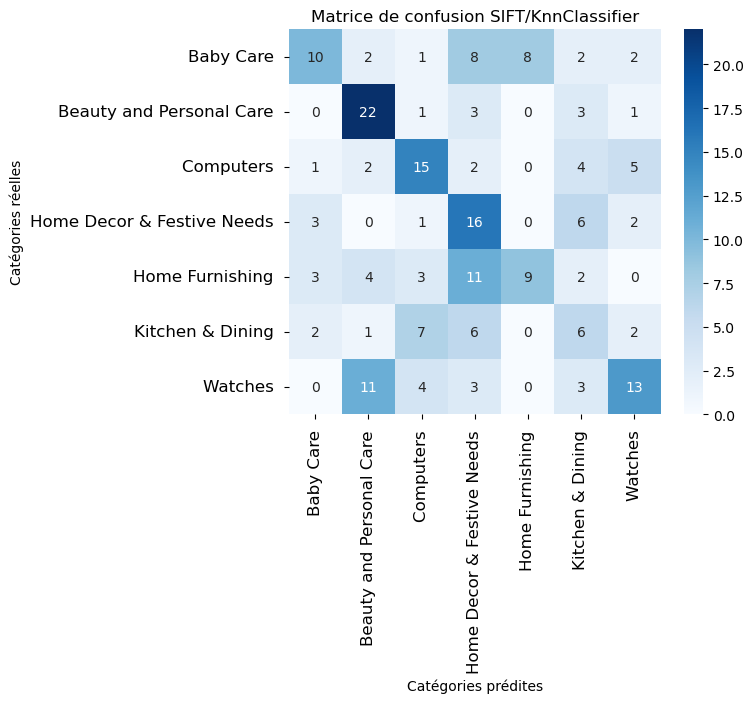

Accuracy : 0.4523809523809524


In [42]:
plt.figure( figsize=(6,5))
sns.heatmap(conf_mat, annot=True, cmap='Blues')
plt.xticks(np.arange(0.5, 7.5, 1), label.classes_, rotation = 90, fontsize=12)
plt.yticks(np.arange(0.5, 7.5, 1), label.classes_, rotation = 0, fontsize=12)
plt.xlabel('Catégories prédites')
plt.ylabel('Catégories réelles')
plt.title('Matrice de confusion SIFT/KnnClassifier')
plt.show()

print("Accuracy :", df_800.loc['KNN Classifier','Test_acc'])

## Réseaux de neurones convolutifs

- première approche sans data augmentation
- seconde approche avec data augmentation
- test de différents batch_size 

### Approche par Dataset sans data augmentation

In [287]:
unique_cat = df['label'].unique()

#### Triage des images pour le changement via le modele
Stockage des images dans des fichiers (pré-crées)

In [290]:
for n in unique_cat:
    
    df_int = df.loc[df['label']==n]
    
    for r,l in df_int.iterrows():
        img = cv2.imread(l['image'])
        name = l['image'].split('/')[3]
        cv2.imwrite('./Images/{}/{}'.format(n,name), img)
        
    print("Categorie '{}' faite".format(n))

Categorie '4' faite
Categorie '0' faite
Categorie '6' faite
Categorie '3' faite
Categorie '5' faite
Categorie '1' faite
Categorie '2' faite


#### Split en 2 fichiers

- Chargement du module split-folders, qui split alétoirement un dataset à partir des des fichiers, en un fichier train et un fichier test

pip install split-folders

In [1]:
import splitfolders
# Split du dossier de façon aléatoire 80% train , 20% test
splitfolders.ratio("./Images/", output="./For_Model", seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 1050 files [00:02, 484.98 files/s]


In [185]:
# Fichier Train
path_train = "./For_Model/train/"
# Fichier Test
path_test = "./For_Model/val/"

In [209]:
df_cnn = pd.DataFrame(columns = ['Train_acc', 'Val_acc', 'Test_acc'])

### Fonctions Communes

In [207]:
#Fonction qui permet de créer les tenseurs qui serviront pour entrainer le modele

def dataset_fct(path, validation_split=0, data_type=None, batch_size=32) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [242]:
# Fonction qui crée un modele sans data augmentation

def create_model() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [208]:
#Fonction qui permet de créer un modèle avec la data augmentation

def create_model_fct() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

### Création et entrainement d'un modele

In [249]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [250]:
# Création du modèle
with tf.device('/gpu:0'): 
    model_sans = create_model()

# Création du callback
model_sans_save_path = "./model_sans_best_weights.h5"
checkpoint = ModelCheckpoint(model_sans_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [251]:
with tf.device('/gpu:0'): 
    history_sans = model_sans.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=32, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 6.2087 - accuracy: 0.4794
Epoch 1: val_loss improved from inf to 1.74711, saving model to .\model_sans_best_weights.h5
20/20 [==============================] - 91s 5s/step - loss: 6.2087 - accuracy: 0.4794 - val_loss: 1.7471 - val_accuracy: 0.7190
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.0578 - accuracy: 0.7143
Epoch 2: val_loss improved from 1.74711 to 1.43107, saving model to .\model_sans_best_weights.h5
20/20 [==============================] - 89s 4s/step - loss: 2.0578 - accuracy: 0.7143 - val_loss: 1.4311 - val_accuracy: 0.7476
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.4499 - accuracy: 0.7349
Epoch 3: val_loss improved from 1.43107 to 1.20994, saving model to .\model_sans_best_weights.h5
20/20 [==============================] - 90s 5s/step - loss: 1.4499 - accuracy: 0.7349 - val_loss: 1.2099 - val_accuracy: 0.7762
Epoch 4/50
20/20 [==========================

In [255]:
# Score du dernier epoch

loss, accuracy_train = model_sans.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy_val = model_sans.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 57s 3s/step - loss: 0.1301 - accuracy: 0.9540
Training Accuracy   : 0.7667

7/7 [==============================] - 20s 3s/step - loss: 1.0854 - accuracy: 0.7762
Validation Accuracy :  0.7667


In [256]:
# Score de l'epoch optimal

model_sans.load_weights(model_sans_save_path)

loss, accuracy = model_sans.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy_test = model_sans.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7762
Test Accuracy       :  0.7762


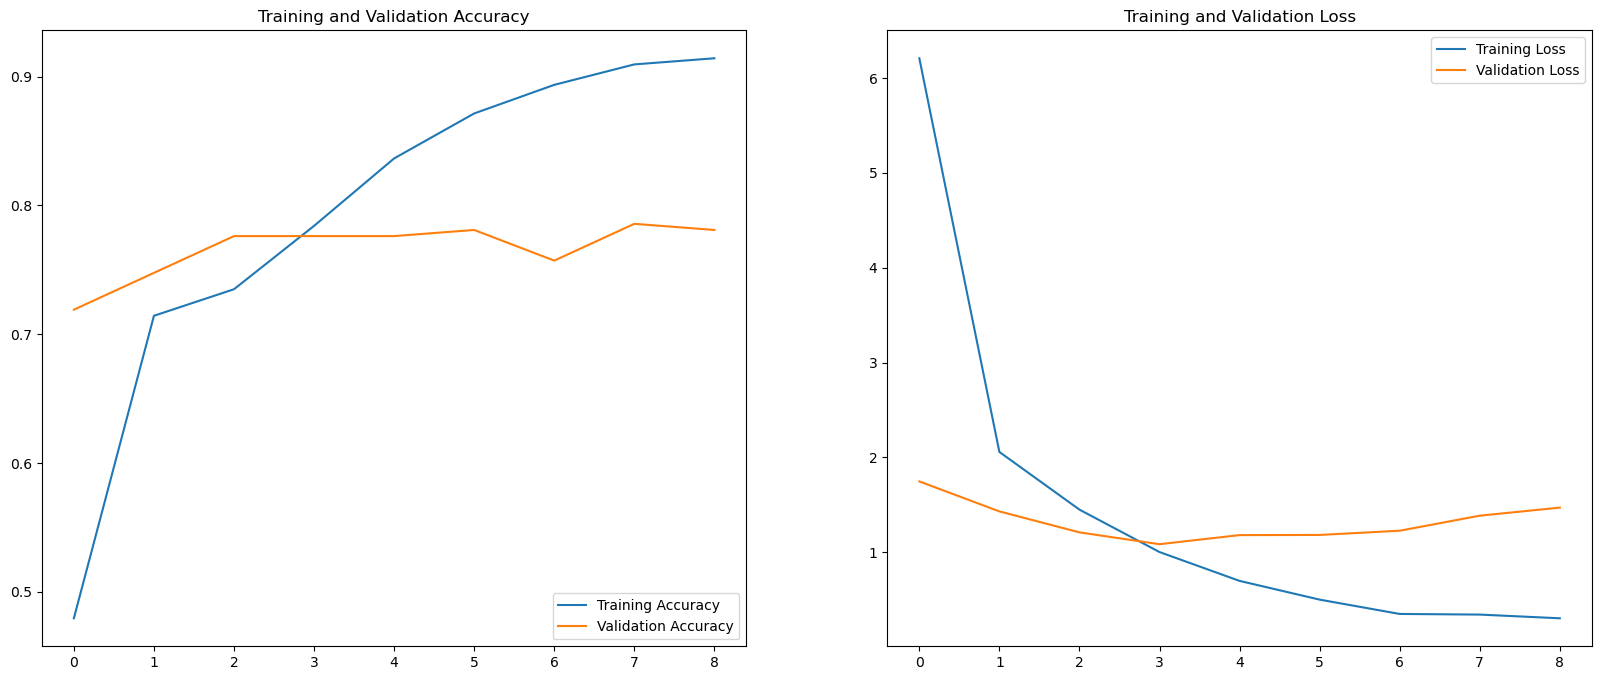

In [257]:
acc_sans= history_sans.history['accuracy']
val_acc_sans = history_sans.history['val_accuracy']

loss_sans = history_sans.history['loss']
val_loss_sans = history_sans.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_sans, label='Training Accuracy')
plt.plot(epochs_range, val_acc_sans, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_sans, label='Training Loss')
plt.plot(epochs_range, val_loss_sans, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [258]:
df_cnn.loc["Sans", :] = [accuracy_train, accuracy_val, accuracy_test]

## Réseaux de neurones avec Data Augmentation

### Création et entrainement d'un modele

#### Batch_Size

Faire varier la taille des lots 32, puis 64 et enfin 1

##### batch_size = 32

In [210]:
# Création du modèle
with tf.device('/gpu:0'): 
    model_32 = create_model_fct()

# Création du callback
model_32_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [211]:
# Batch_Size = 32

# Train
dataset_train_32 = dataset_fct(path_train, validation_split=0.25, data_type='training')
# Validation
dataset_val_32 = dataset_fct(path_train, validation_split=0.25, data_type='validation')
# Test
dataset_test_32 = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [212]:
with tf.device('/gpu:0'): 
    history_32 = model_32.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=32, epochs=30, callbacks=callbacks_list, verbose=1)


Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 1.8845 - accuracy: 0.2508
Epoch 1: val_loss improved from inf to 1.43316, saving model to .\model_best_weights.h5
20/20 [==============================] - 79s 4s/step - loss: 1.8845 - accuracy: 0.2508 - val_loss: 1.4332 - val_accuracy: 0.6000
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 1.3643 - accuracy: 0.5444
Epoch 2: val_loss improved from 1.43316 to 1.15088, saving model to .\model_best_weights.h5
20/20 [==============================] - 85s 4s/step - loss: 1.3643 - accuracy: 0.5444 - val_loss: 1.1509 - val_accuracy: 0.6524
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.1056 - accuracy: 0.6540
Epoch 3: val_loss improved from 1.15088 to 0.99952, saving model to .\model_best_weights.h5
20/20 [==============================] - 89s 4s/step - loss: 1.1056 - accuracy: 0.6540 - val_loss: 0.9995 - val_accuracy: 0.7333
Epoch 4/30
20/20 [==============================] - ETA: 0s

Epoch 20/30
20/20 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.8397
Epoch 20: val_loss improved from 0.70669 to 0.70093, saving model to .\model_best_weights.h5
20/20 [==============================] - 91s 5s/step - loss: 0.5049 - accuracy: 0.8397 - val_loss: 0.7009 - val_accuracy: 0.7714
Epoch 21/30
20/20 [==============================] - ETA: 0s - loss: 0.4827 - accuracy: 0.8333
Epoch 21: val_loss improved from 0.70093 to 0.70033, saving model to .\model_best_weights.h5
20/20 [==============================] - 92s 5s/step - loss: 0.4827 - accuracy: 0.8333 - val_loss: 0.7003 - val_accuracy: 0.7714
Epoch 22/30
20/20 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8587
Epoch 22: val_loss improved from 0.70033 to 0.69635, saving model to .\model_best_weights.h5
20/20 [==============================] - 99s 5s/step - loss: 0.4546 - accuracy: 0.8587 - val_loss: 0.6963 - val_accuracy: 0.7571
Epoch 23/30
20/20 [==============================

In [213]:
# Score du dernier epoch

loss_train_32, accuracy_train_32 = model_32.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train_32))
print()
loss_val_32, accuracy_val_32 = model_32.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_32))

20/20 [==============================] - 68s 3s/step - loss: 0.2792 - accuracy: 0.9159
Training Accuracy   : 0.9159

7/7 [==============================] - 23s 3s/step - loss: 0.7071 - accuracy: 0.7667
Validation Accuracy :  0.7667


In [214]:
# Score de l'epoch optimal

model_32.load_weights(model_32_save_path)

loss_val_32b, accuracy_val_32b = model_32.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_32b))

loss_test_32, accuracy_test_32 = model_32.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_32))


Validation Accuracy :  0.7571
Test Accuracy       :  0.7810


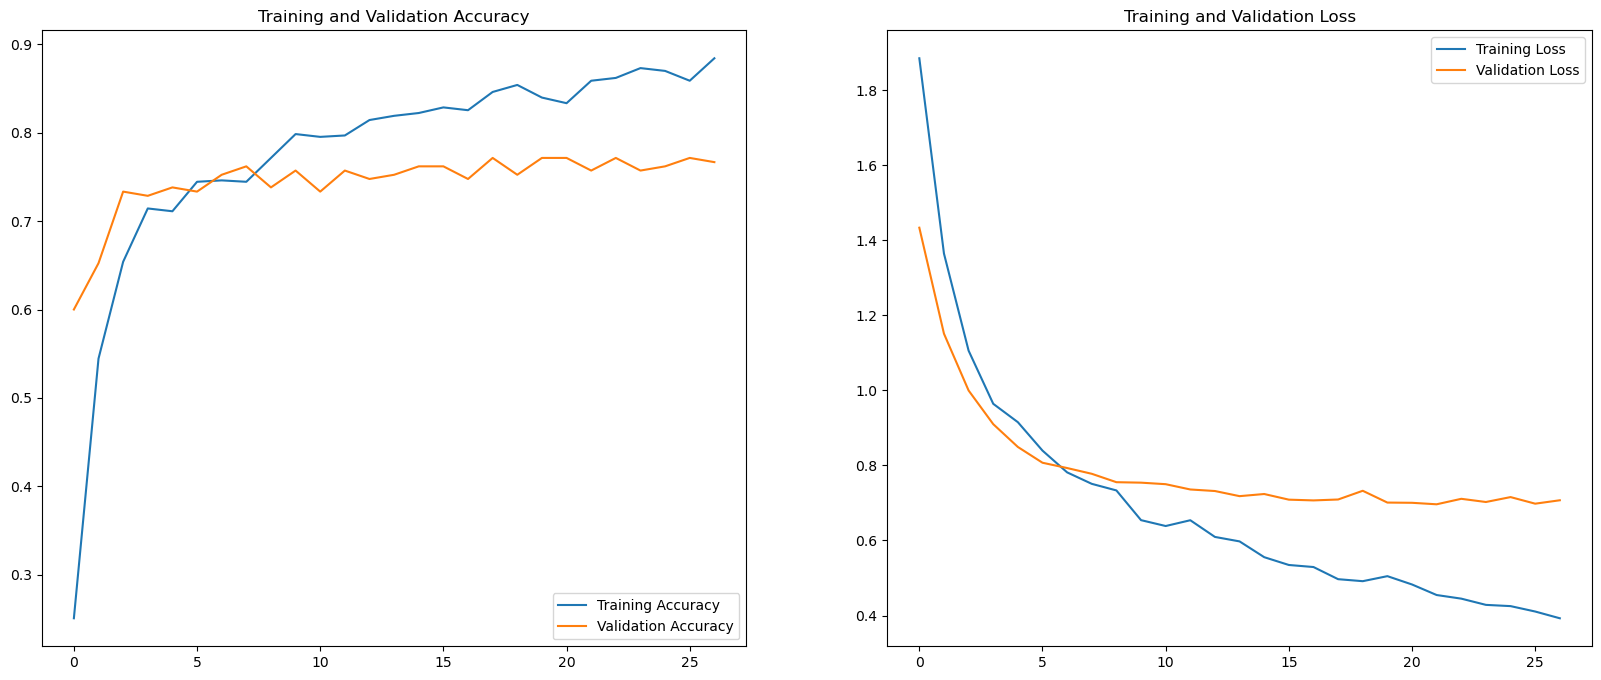

In [216]:
acc_32 = history_32.history['accuracy']
val_acc_32 = history_32.history['val_accuracy']

loss_32 = history_32.history['loss']
val_loss_32 = history_32.history['val_loss']

epochs_range = range(27)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_32, label='Training Accuracy')
plt.plot(epochs_range, val_acc_32, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_32, label='Training Loss')
plt.plot(epochs_range, val_loss_32, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [217]:
df_cnn.loc['BS_32', :] = [accuracy_train_32, accuracy_val_32, accuracy_test_32 ]

##### batch_size = 64

In [239]:
# Création du modèle
with tf.device('/gpu:0'): 
    model_64 = create_model_fct()

# Création du callback
model_64_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                     

In [240]:
# Batch_Size = 64

# Train
dataset_train_64 = dataset_fct(path_train, validation_split=0.25, data_type='training', batch_size=64)
# Validation
dataset_val_64 = dataset_fct(path_train, validation_split=0.25, data_type='validation', batch_size=64)
# Test
dataset_test_64 = dataset_fct(path_test, validation_split=0, data_type=None, batch_size=64)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [241]:
with tf.device('/gpu:0'): 
    history_64 = model_64.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=64, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.9001 - accuracy: 0.2333
Epoch 1: val_loss improved from inf to 1.50876, saving model to .\model_best_weights.h5
20/20 [==============================] - 78s 4s/step - loss: 1.9001 - accuracy: 0.2333 - val_loss: 1.5088 - val_accuracy: 0.5429
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.3885 - accuracy: 0.5619
Epoch 2: val_loss improved from 1.50876 to 1.20573, saving model to .\model_best_weights.h5
20/20 [==============================] - 81s 4s/step - loss: 1.3885 - accuracy: 0.5619 - val_loss: 1.2057 - val_accuracy: 0.6762
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1463 - accuracy: 0.6603
Epoch 3: val_loss improved from 1.20573 to 1.01404, saving model to .\model_best_weights.h5
20/20 [==============================] - 84s 4s/step - loss: 1.1463 - accuracy: 0.6603 - val_loss: 1.0140 - val_accuracy: 0.7238
Epoch 4/50
20/20 [==============================] - ETA: 0s

In [235]:
# Score du dernier epoch

loss_train_64, accuracy_train_64 = model_64.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train_64))
print()
loss_val_64, accuracy_val_64 = model_64.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_64))

20/20 [==============================] - 67s 3s/step - loss: 0.2355 - accuracy: 0.9270
Training Accuracy   : 0.9270

7/7 [==============================] - 22s 3s/step - loss: 0.7134 - accuracy: 0.7524
Validation Accuracy :  0.7524


In [236]:
# Score de l'epoch optimal

model_64.load_weights(model_64_save_path)

loss_val_64b, accuracy_val_64b = model_64.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_64b))

loss_test_64, accuracy_test_64 = model_64.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_64))


Validation Accuracy :  0.7667
Test Accuracy       :  0.7762


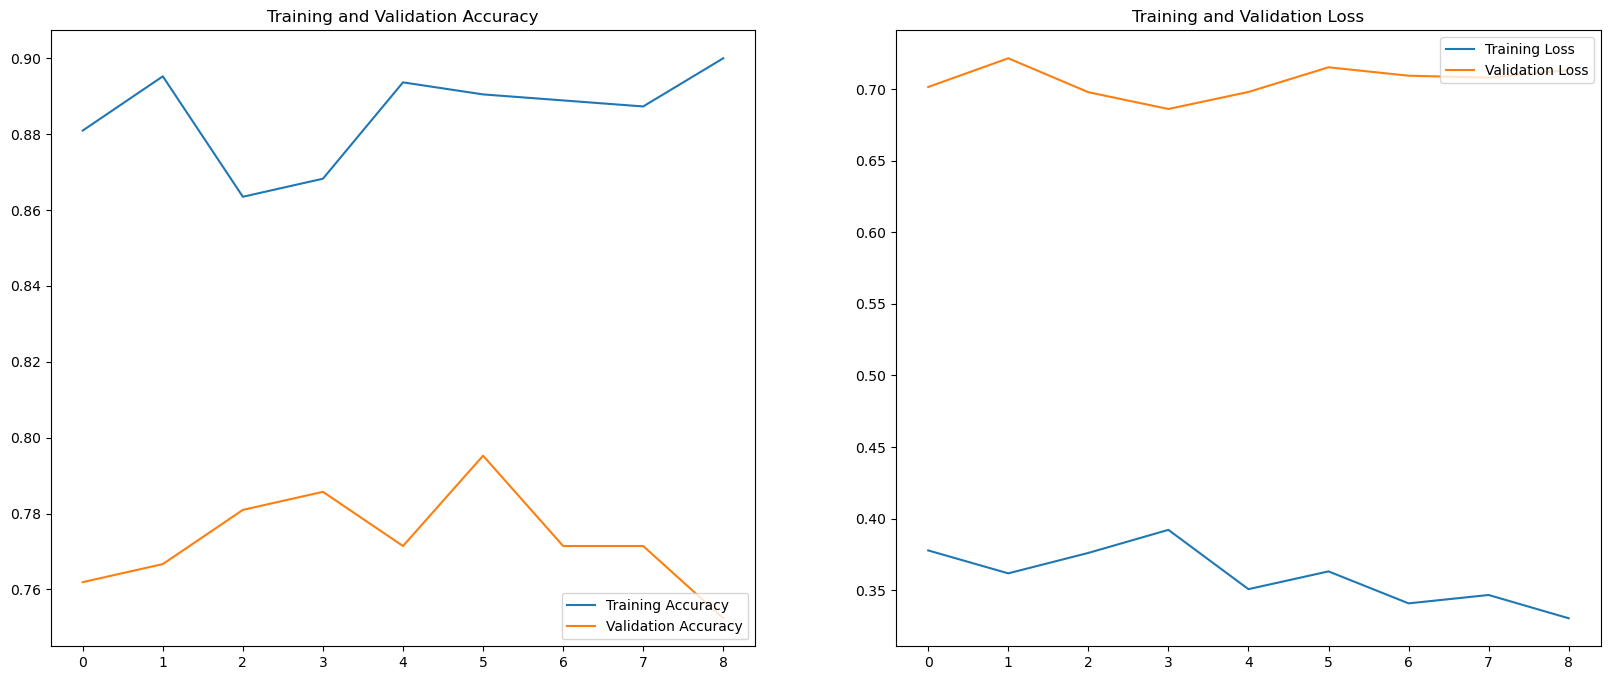

In [238]:
acc_64 = history_64.history['accuracy']
val_acc_64 = history_64.history['val_accuracy']

loss_64 = history_64.history['loss']
val_loss_64 = history_64.history['val_loss']

epochs_range = range(9)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_64, label='Training Accuracy')
plt.plot(epochs_range, val_acc_64, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_64, label='Training Loss')
plt.plot(epochs_range, val_loss_64, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [224]:
df_cnn.loc['BS_64', :] = [accuracy_train_64, accuracy_val_64, accuracy_test_64 ]

##### Batch_size = 1

In [225]:
# Création du modèle
with tf.device('/gpu:0'): 
    model_1 = create_model_fct()

# Création du callback
model_1_save_path = "./model_best_weights.h5"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                      

In [226]:
# Batch_Size = 1

# Train
dataset_train_1 = dataset_fct(path_train, validation_split=0.25, data_type='training', batch_size=1)
# Validation
dataset_val_1 = dataset_fct(path_train, validation_split=0.25, data_type='validation', batch_size=1)
# Test
dataset_test_1 = dataset_fct(path_test, validation_split=0, data_type=None, batch_size=1)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [227]:
with tf.device('/gpu:0'): 
    history_1 = model_1.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=1, epochs=30, callbacks=callbacks_list, verbose=1)


Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 1.8609 - accuracy: 0.2762
Epoch 1: val_loss improved from inf to 1.38894, saving model to .\model_best_weights.h5
20/20 [==============================] - 94s 4s/step - loss: 1.8609 - accuracy: 0.2762 - val_loss: 1.3889 - val_accuracy: 0.6905
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 1.3443 - accuracy: 0.5635
Epoch 2: val_loss improved from 1.38894 to 1.12905, saving model to .\model_best_weights.h5
20/20 [==============================] - 92s 5s/step - loss: 1.3443 - accuracy: 0.5635 - val_loss: 1.1291 - val_accuracy: 0.6571
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 1.1090 - accuracy: 0.6524
Epoch 3: val_loss improved from 1.12905 to 0.94610, saving model to .\model_best_weights.h5
20/20 [==============================] - 92s 5s/step - loss: 1.1090 - accuracy: 0.6524 - val_loss: 0.9461 - val_accuracy: 0.7571
Epoch 4/30
20/20 [==============================] - ETA: 0s

In [228]:
# Score du dernier epoch

loss_train_1, accuracy_train_1 = model_1.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_train_1))
print()
loss_val_1, accuracy_val_1 = model_1.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_1))

20/20 [==============================] - 68s 3s/step - loss: 0.3020 - accuracy: 0.9016
Training Accuracy   : 0.9016

7/7 [==============================] - 24s 3s/step - loss: 0.6994 - accuracy: 0.7667
Validation Accuracy :  0.7667


In [229]:
# Score de l'epoch optimal

model_1.load_weights(model_1_save_path)

loss_val_1b, accuracy_val_1b = model_1.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_val_1b))

loss_test_1, accuracy_test_1 = model_1.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_test_1))


Validation Accuracy :  0.7667
Test Accuracy       :  0.7762


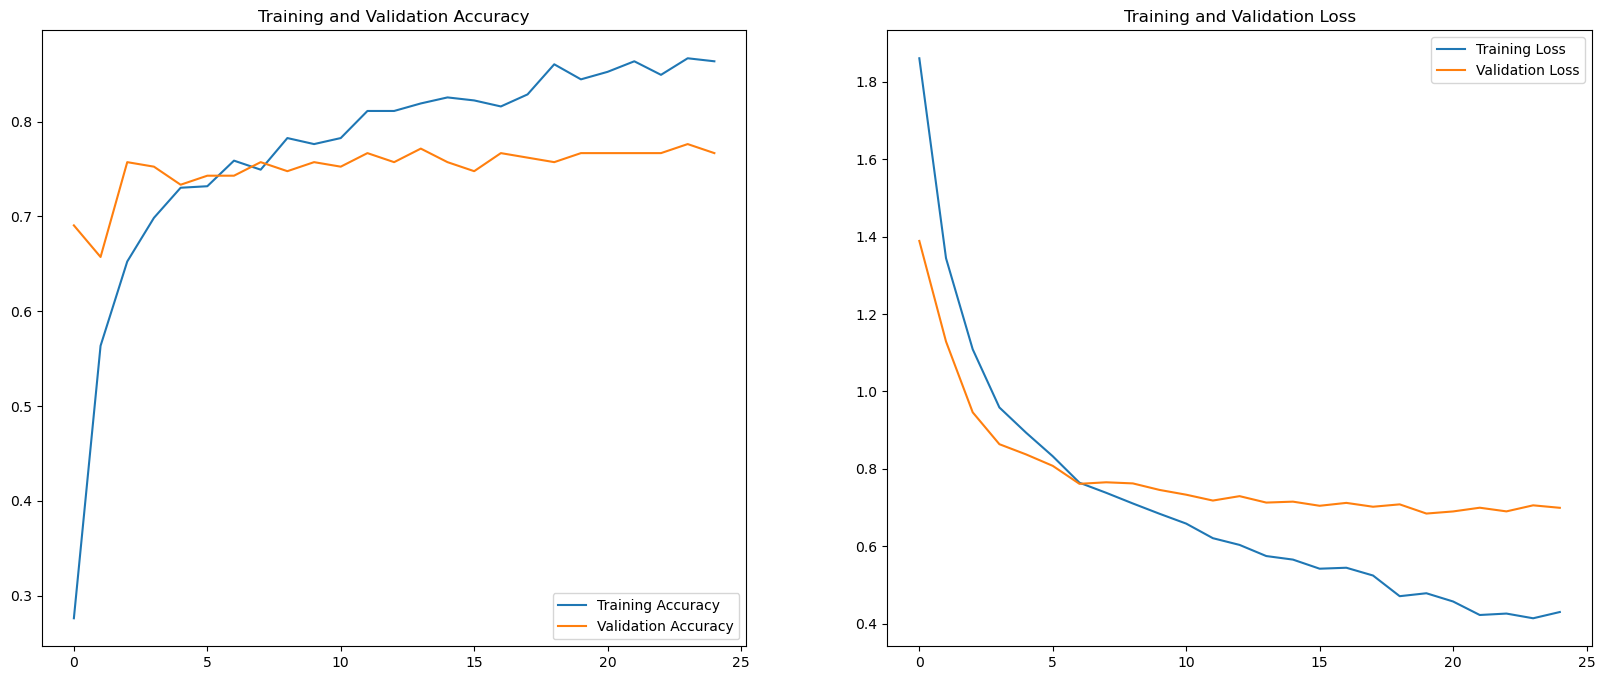

In [231]:
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']

loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1, label='Training Loss')
plt.plot(epochs_range, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [232]:
df_cnn.loc['BS_1', :] = [accuracy_train_1, accuracy_val_1, accuracy_test_1 ]

In [259]:
df_cnn

Train_acc   Val_acc  Test_acc
BS_32  0.915873  0.766667  0.780952
BS_64  0.912698  0.766667  0.771429
BS_1   0.901587  0.766667   0.77619
Sans   0.953968   0.77619  0.766667